<a href="https://colab.research.google.com/github/aslyldrm/Temporal-Link-Prediction-Using-Graph-Neural-Networks-PyTorch-Geometric-Temporal/blob/main/DySAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)


2.6.0+cu124


In [ ]:
node_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/node_features.csv.gz",names=['node_id', "feat_0", 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7'],header=None)
edge_features = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/edge_type_features.csv.gz",names=['edge_type_id', "feat_0", 'feat_1', 'feat_2',],header=None)
test_data = pd.read_csv("/content/drive/MyDrive/sertifikalarım/Social_Network/input_A.csv.gz",names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time'],header=None)
edges_train = pd.read_csv('/content/drive/MyDrive/sertifikalarım/Social_Network/edges_train_A.csv.gz',names=['src_id', 'dst_id', 'edge_type', 'timestamp'],header=None)



In [ ]:
test_data

,src_id,dst_id,edge_type,start_time,end_time
0,19,2867,4,1498693690,1498840508
1,19,2880,8,1496420943,1496640465
2,19,3990,20,1496308468,1496472407
3,19,5186,234,1496438901,1496571525
4,19,6486,108,1496294861,1496462528
...,...,...,...,...,...
199995,69980,49214,176,1494875670,1494996140
199996,69980,52874,33,1498584288,1498694102
199997,69980,55746,209,1497952740,1498081488
199998,69980,60642,71,1497166072,1497356374


In [ ]:
edge_features

,edge_type_id,feat_0,feat_1,feat_2
0,0,56,16,32
1,1,179,15,70
2,2,65,6,62
3,3,104,12,86
4,4,114,3,20
...,...,...,...,...
243,243,196,17,98
244,244,21,15,70
245,245,92,10,26
246,246,1,1,109


In [ ]:
node_features

,node_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7
0,2,29,-1,-1,-1,-1,9,-1,-1
1,5,29,-1,-1,-1,-1,-1,-1,20
2,11,11,-1,-1,-1,-1,-1,-1,20
3,16,13,-1,-1,-1,-1,155,-1,20
4,19,-1,-1,-1,-1,-1,40,-1,-1
...,...,...,...,...,...,...,...,...,...
19437,69967,29,-1,-1,-1,-1,86,-1,20
19438,69971,0,-1,-1,-1,-1,-1,-1,20
19439,69973,29,-1,-1,-1,-1,37,-1,-1
19440,69980,29,-1,-1,-1,-1,59,-1,-1


In [ ]:
import networkx as nx

In [ ]:
def visualize_graph(snapshot, node_feats, num_nodes_to_plot=100, title="Graph Snapshot"):
    edge_index = snapshot['edge_index'].numpy()

    if edge_index.size == 0:
        print(f"Skipping visualization for {title} (no edges)")
        return

    G = nx.Graph()
    unique_nodes = np.unique(edge_index)

    if len(unique_nodes) > num_nodes_to_plot:
        selected_nodes = np.random.choice(unique_nodes, num_nodes_to_plot, replace=False)
        mask = np.isin(edge_index[0], selected_nodes) & np.isin(edge_index[1], selected_nodes)
        edge_index = edge_index[:, mask]

    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        G.add_edge(src, dst)

    node_colors = node_feats[list(G.nodes)].mean(dim=1).numpy()

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=100
    )

    nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        width=1
    )

    if len(node_colors) > 0:
        plt.colorbar(nodes, label="Node Feature Mean")

    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
unique_nodes = pd.concat([
    edges_train['src_id'],
    edges_train['dst_id'],
    test_data['src_id'],
    test_data['dst_id'],
    node_features['node_id']
]).unique()

node_id_map = {node_id: i for i, node_id in enumerate(sorted(unique_nodes))}

edges_train['src_id'] = edges_train['src_id'].map(node_id_map)
edges_train['dst_id'] = edges_train['dst_id'].map(node_id_map)
node_features['node_id'] = node_features['node_id'].map(node_id_map)
test_data['src_id'] = test_data['src_id'].map(node_id_map)
test_data['dst_id'] = test_data['dst_id'].map(node_id_map)

num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

In [ ]:
print("NaN values in test_data src_id:", test_data['src_id'].isna().sum())
print("NaN values in test_data dst_id:", test_data['dst_id'].isna().sum())

NaN values in test_data src_id: 0
NaN values in test_data dst_id: 0


In [ ]:
num_time_bins = 24
edges_train['time_bin'] = pd.cut(edges_train['timestamp'], bins=num_time_bins, labels=False)

time_bin_edges = pd.cut(edges_train['timestamp'], bins=num_time_bins, retbins=True)[1]

test_data['start_bin'] = pd.cut(test_data['start_time'], bins=time_bin_edges, labels=False)
test_data['end_bin'] = pd.cut(test_data['end_time'], bins=time_bin_edges, labels=False)

test_data['start_bin'] = test_data['start_bin'].fillna(0).astype(int)
test_data['end_bin'] = test_data['end_bin'].fillna(num_time_bins-1).astype(int)

snapshots = []
for time_bin in range(num_time_bins):
    edges_in_bin = edges_train[edges_train['time_bin'] == time_bin]

    if len(edges_in_bin) == 0:
        continue

    src_nodes = edges_in_bin['src_id'].values
    dst_nodes = edges_in_bin['dst_id'].values

    all_src = np.concatenate([src_nodes, dst_nodes])
    all_dst = np.concatenate([dst_nodes, src_nodes])

    edge_index = torch.tensor(
        np.array([all_src, all_dst]),
        dtype=torch.long
    )

    edge_attr_values = None
    try:
        edge_attr_values = edge_features.loc[edges_in_bin.index].drop('edge_type_id', axis=1).values
        edge_attr = torch.tensor(
            np.concatenate([edge_attr_values, edge_attr_values]),
            dtype=torch.float
        )
    except:
        edge_attr = torch.zeros(len(all_src), edge_features.shape[1]-1)

    snapshots.append({
        'edge_index': edge_index,
        'edge_attr': edge_attr
    })

node_feats = torch.zeros(len(node_id_map), node_features.shape[1]-1)
node_feats[node_features['node_id']] = torch.tensor(
    node_features.drop('node_id', axis=1).values,
    dtype=torch.float
)



In [ ]:
snapshots

[{'edge_index': tensor([[   29,    61,   381,  ...,  7989, 13514, 17112],
          [ 7989,  4016, 12686,  ..., 19389, 19389, 19389]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[   29,    29,    29,  ..., 18733, 18681,  7989],
          [ 4194,  7989, 10040,  ..., 18733, 19098, 19118]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[  389,   424,   424,  ...,  2383, 17592,  7989],
          [ 9786,    29,  1121,  ..., 19334, 19389, 19427]]),
  'edge_attr': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])},
 {'edge_index': tensor([[   29,    29,   361,  ..., 13496,  3715,  

In [ ]:
def visualize_embeddings_tsne(model, snapshots, node_feats, title="Node Embeddings Visualization"):

    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import numpy as np

    model.eval()
    with torch.no_grad():
        embeddings = model(snapshots, node_feats)

    final_embeddings = embeddings[-1].cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    reduced_embeddings = tsne.fit_transform(final_embeddings)

    plt.figure(figsize=(12, 10))

    if len(snapshots) > 0:
        last_snapshot = snapshots[-1]
        edge_index = last_snapshot['edge_index'].cpu().numpy()

        unique_nodes, node_degrees = np.unique(edge_index, return_counts=True)

        degree_map = np.zeros(len(final_embeddings))
        for node, degree in zip(unique_nodes, node_degrees):
            if node < len(degree_map):
                degree_map[node] = degree
    else:
        degree_map = np.random.rand(len(final_embeddings))

    scatter = plt.scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=degree_map,
        cmap='viridis',
        alpha=0.7,
        s=50,
        edgecolors='w',
        linewidths=0.5
    )

    plt.colorbar(scatter, label="Node Degree")
    plt.title(f"{title} (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.tight_layout()
    plt.show()

    return reduced_embeddings

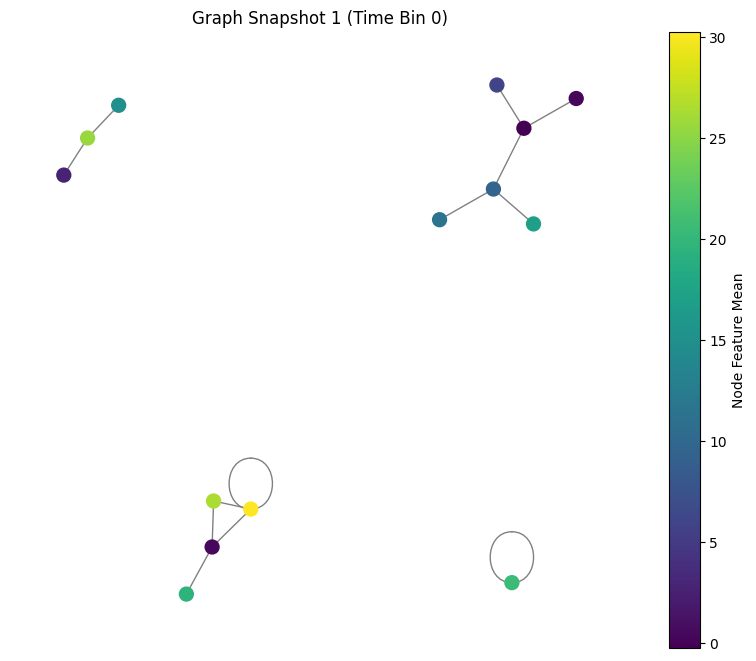

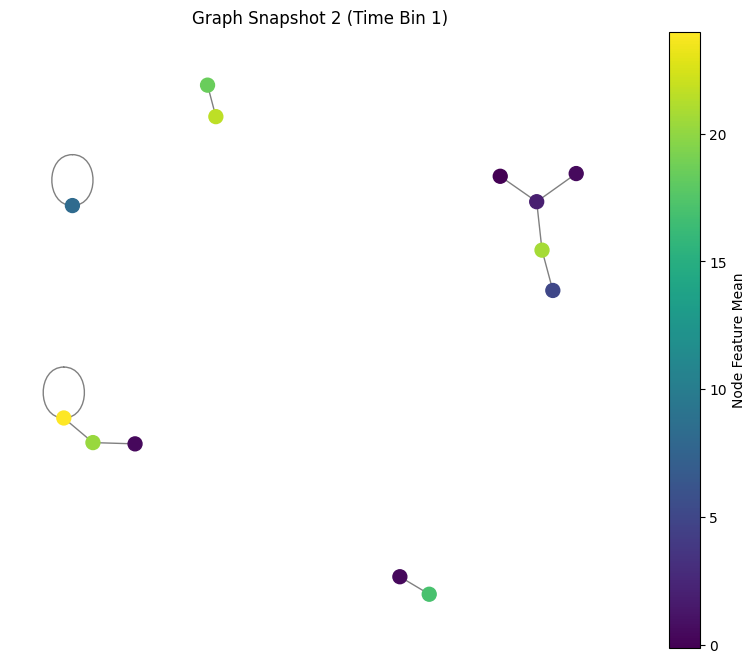

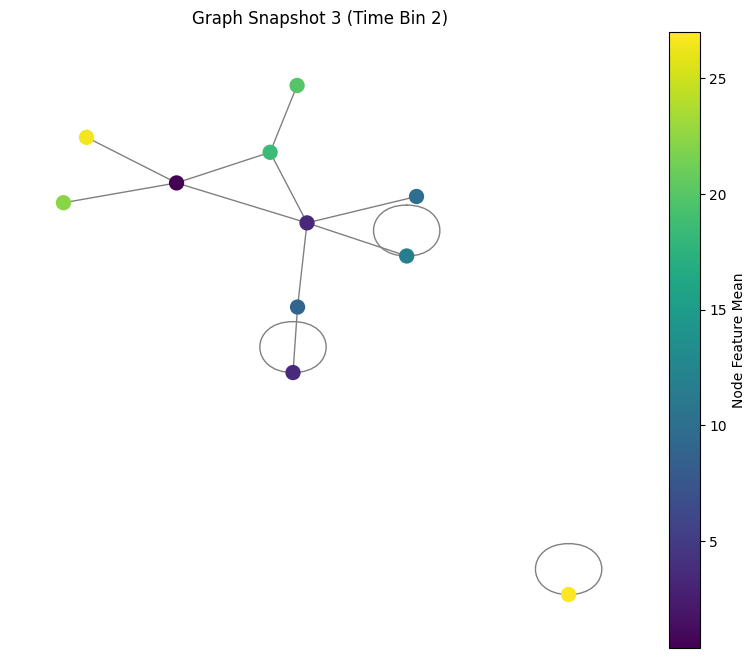

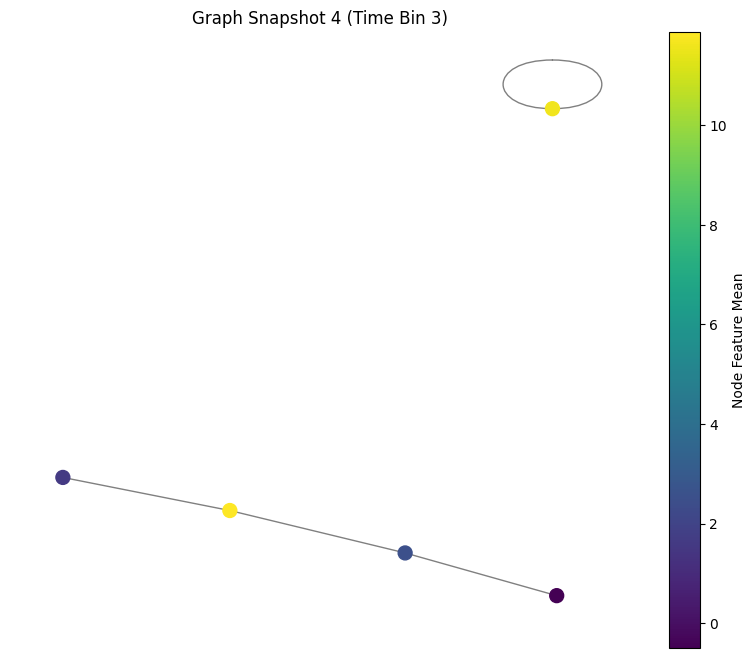

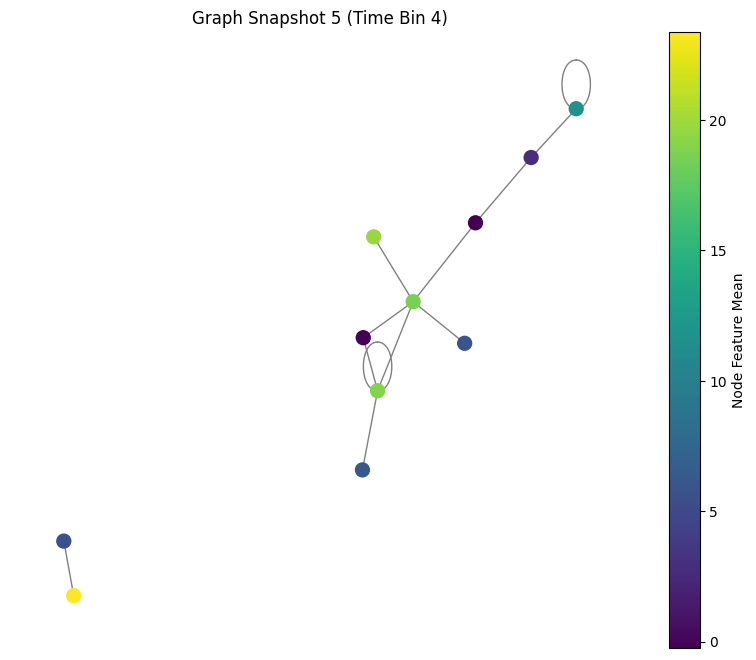

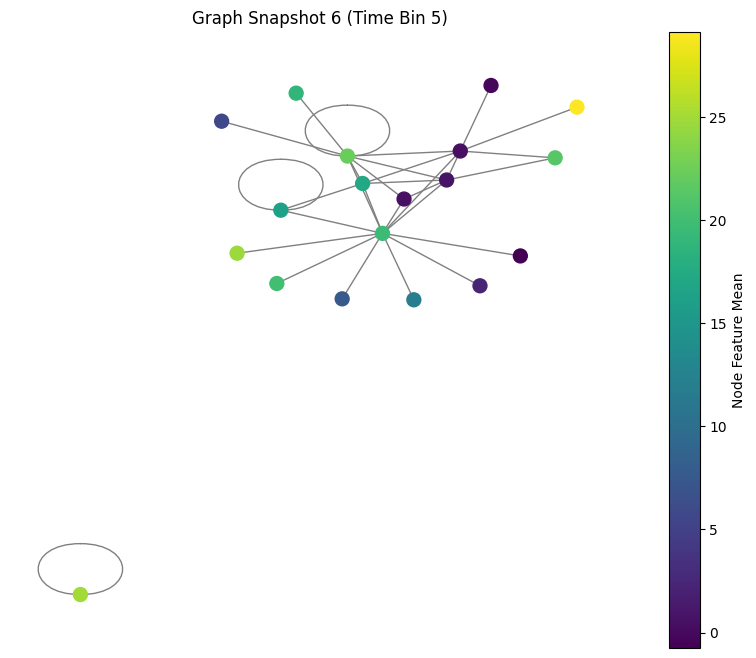

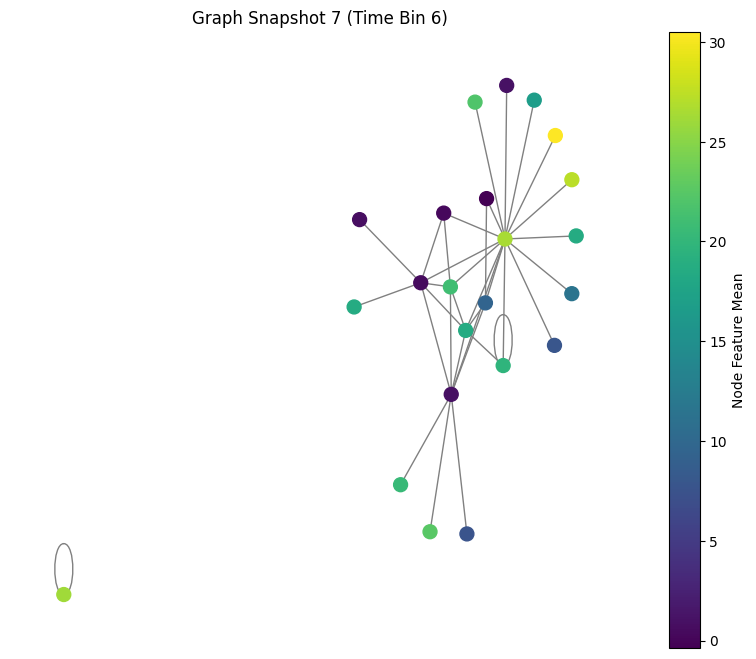

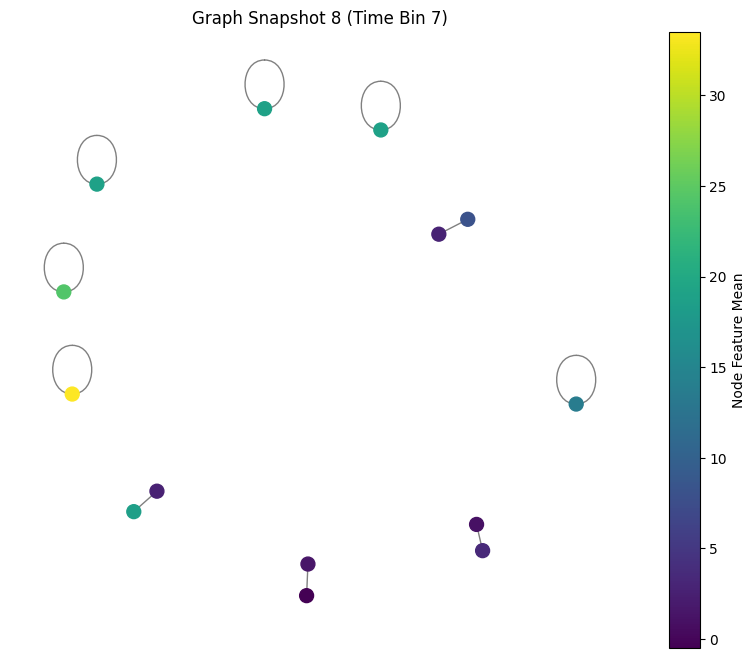

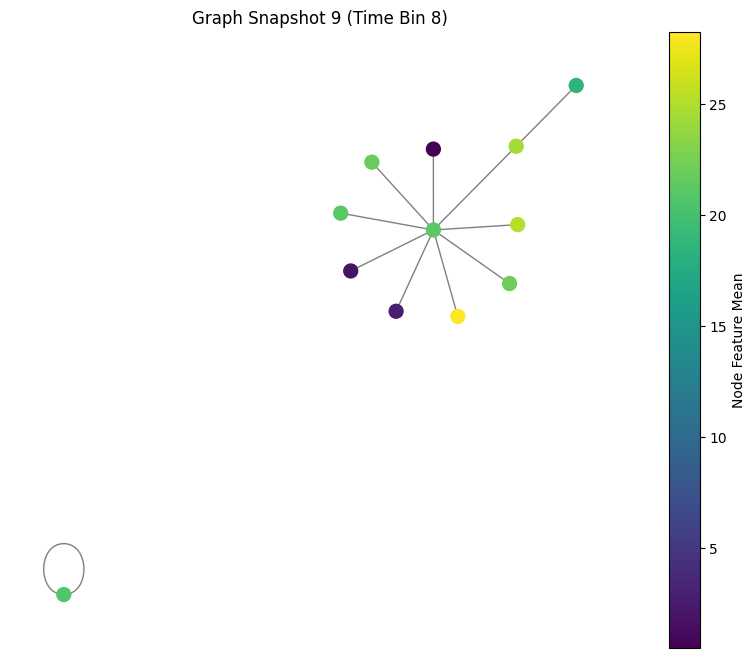

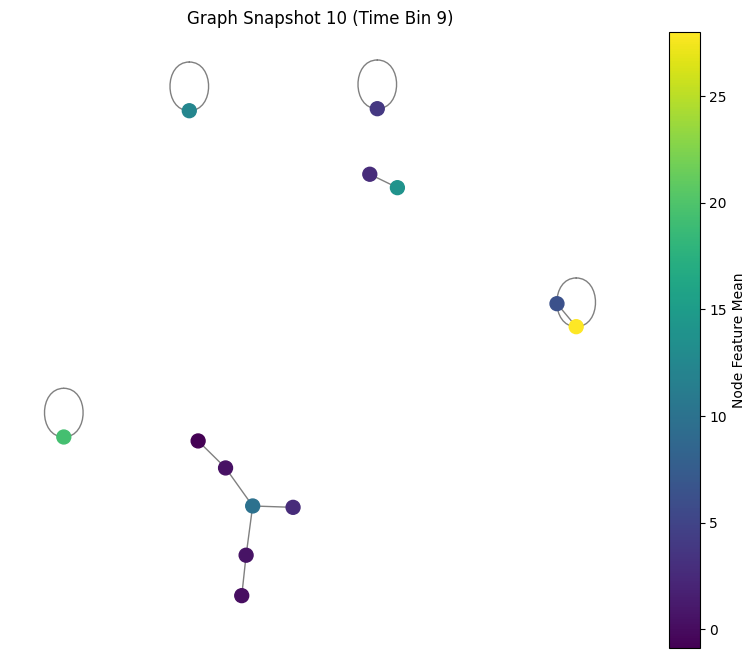

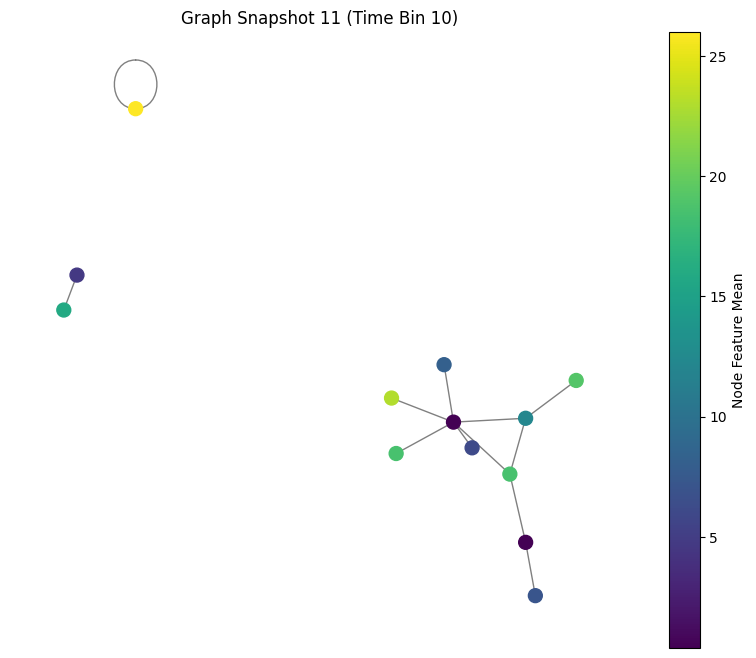

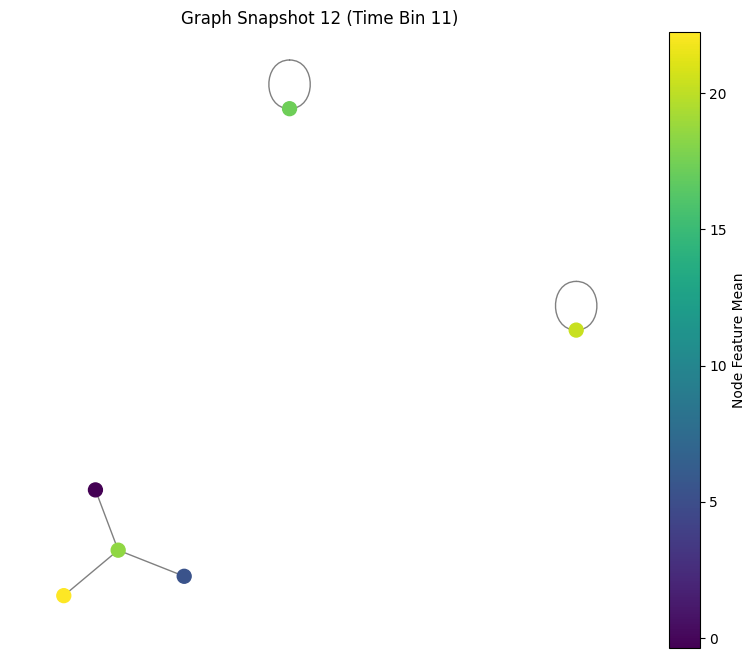

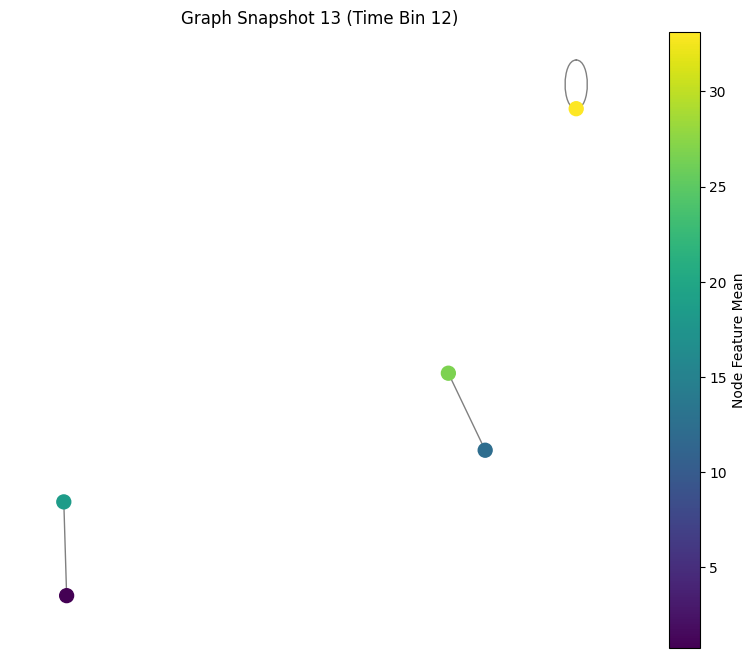

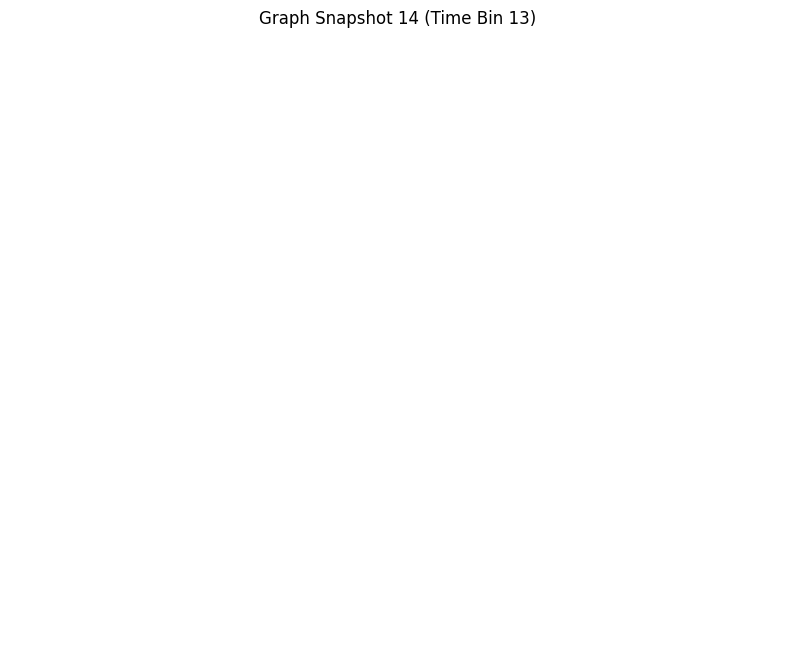

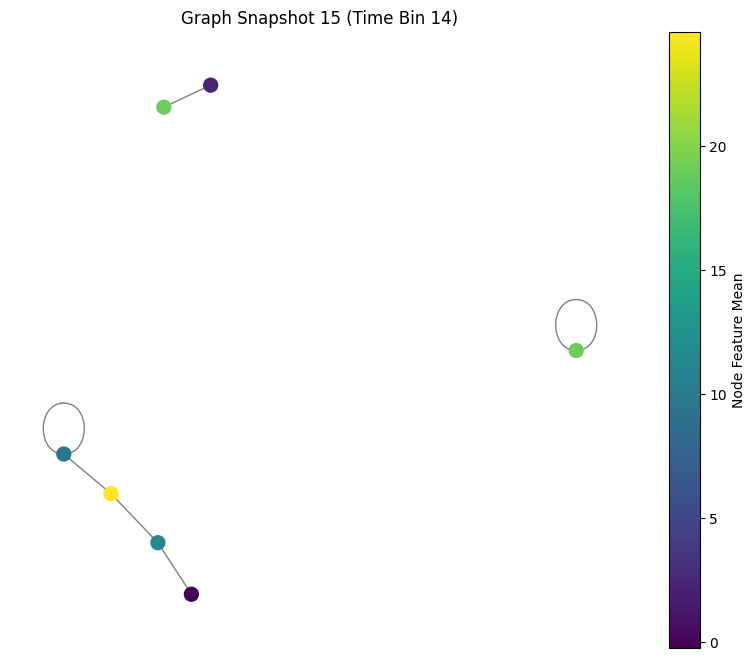

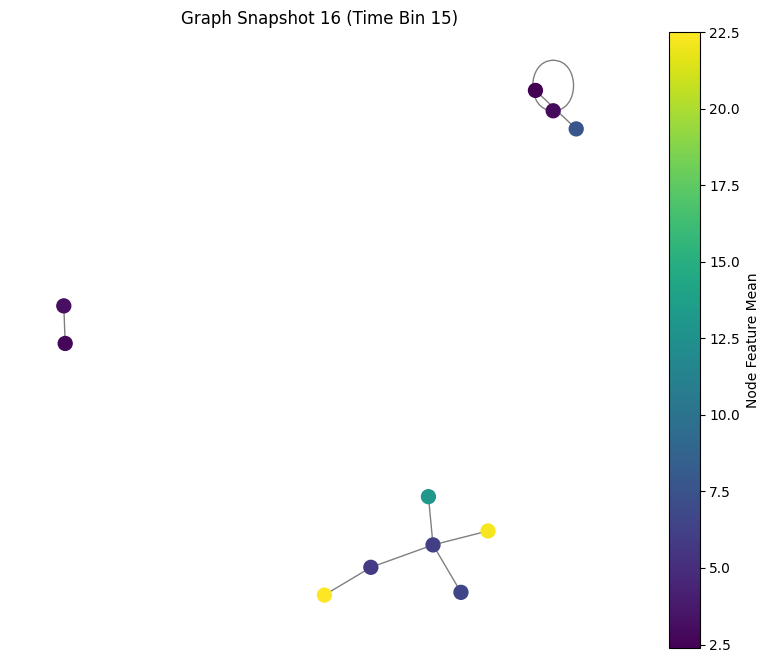

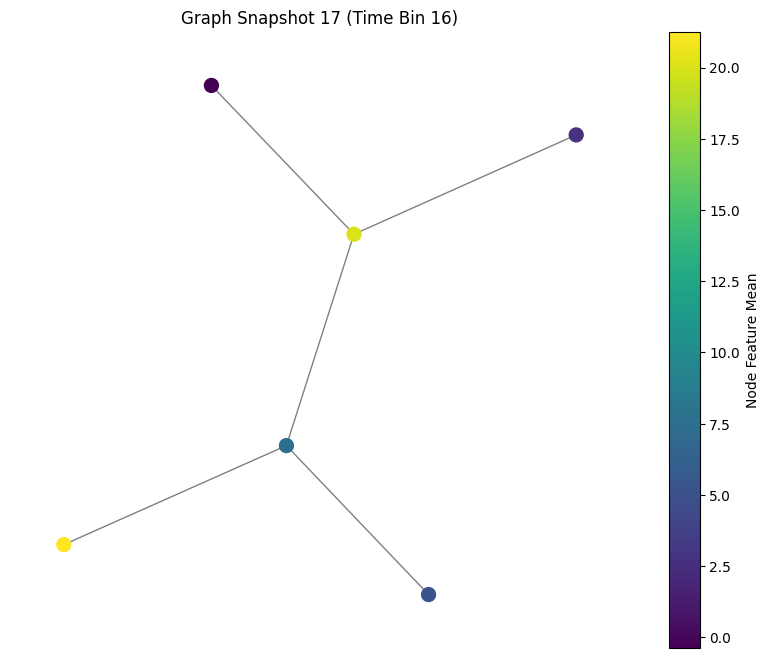

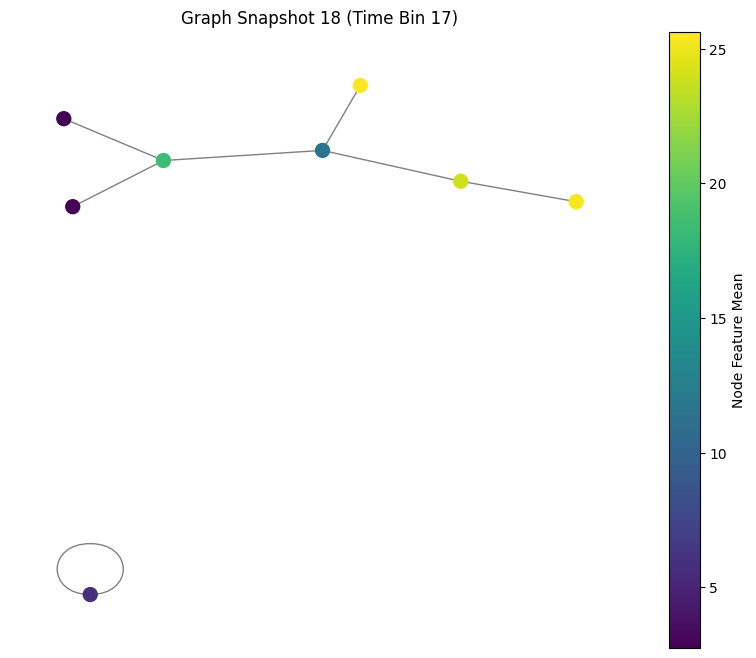

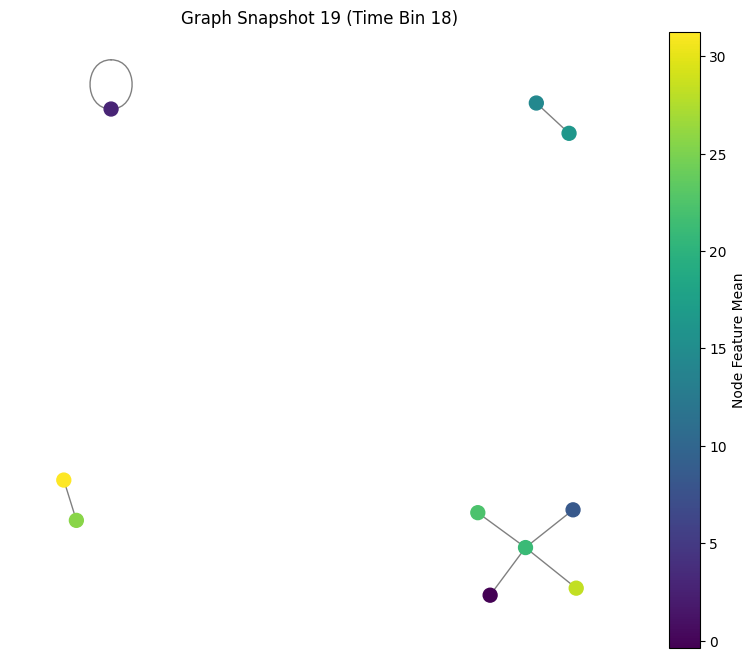

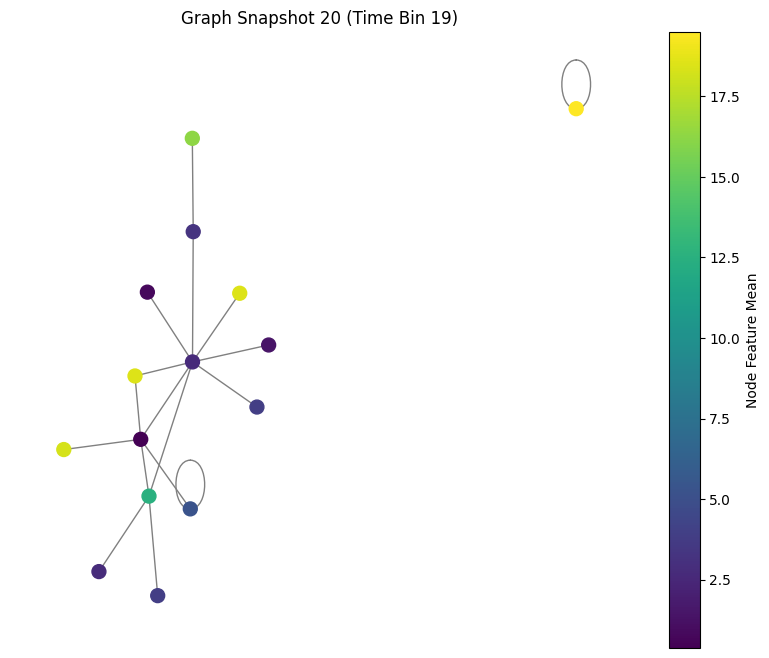

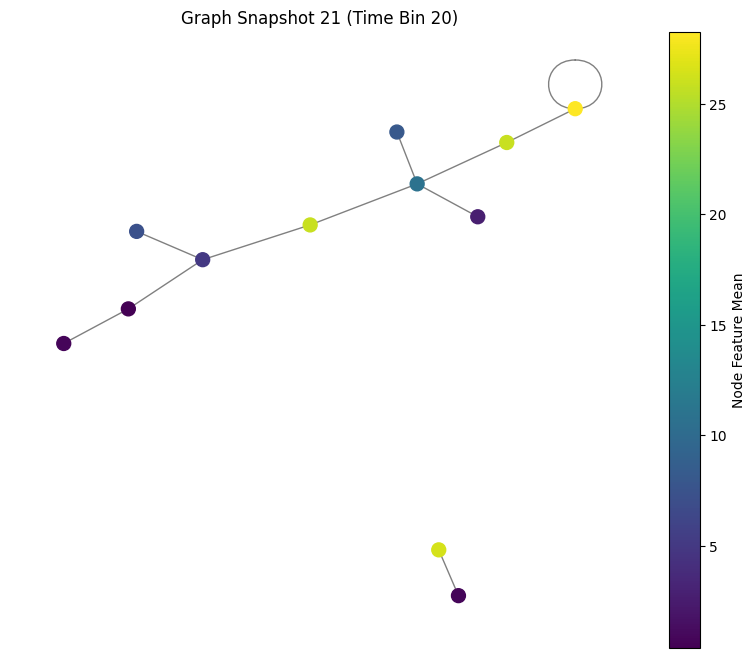

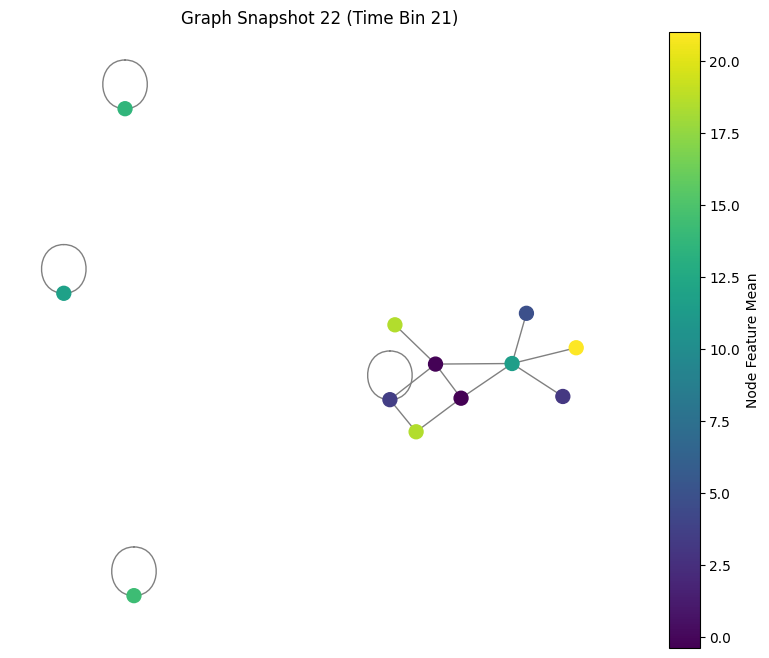

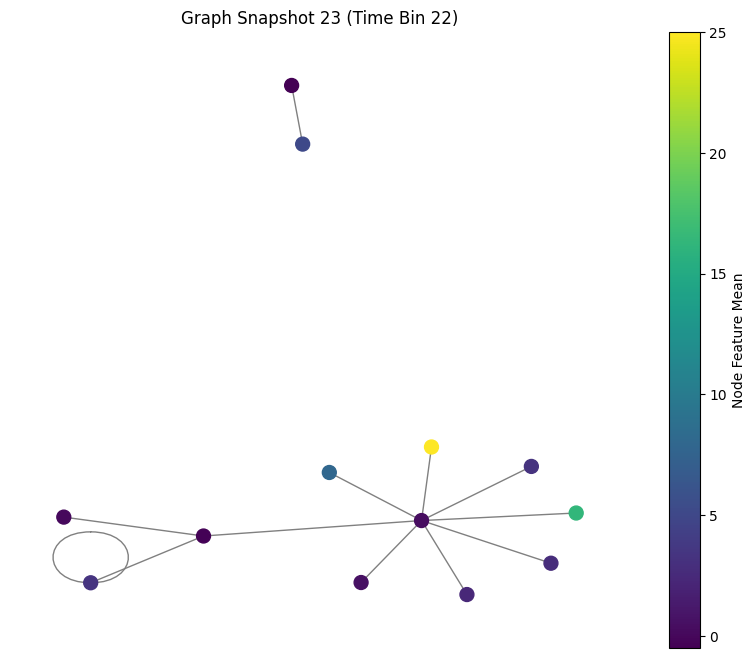

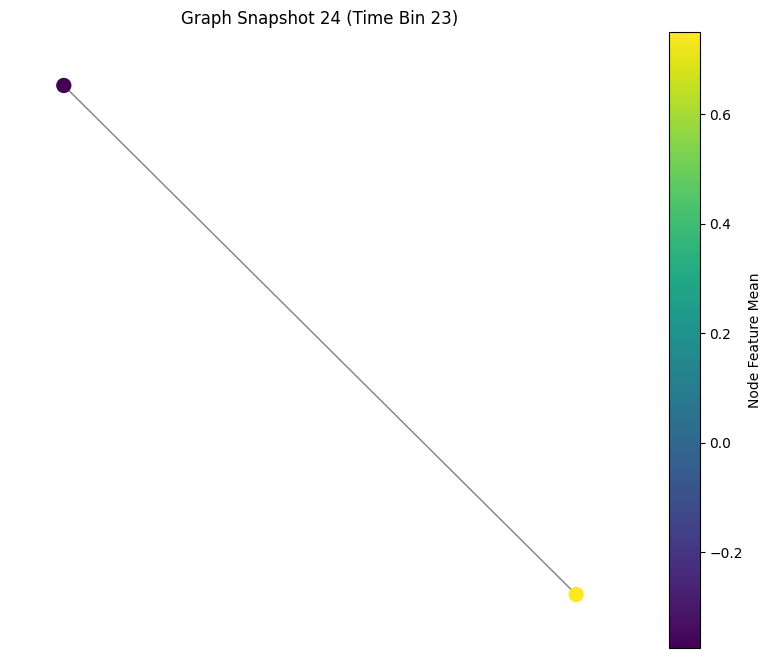

In [ ]:
for i, snapshot in enumerate(snapshots):
    visualize_graph(
        snapshot,
        node_feats,
        title=f"Graph Snapshot {i+1} (Time Bin {i})"
    )

In [ ]:
class DySAT(nn.Module):
    def __init__(self, num_nodes, node_feat_dim, edge_feat_dim, time_steps, heads=2):
        super().__init__()
        self.heads = heads

        self.feat_transform = nn.Linear(node_feat_dim, node_feat_dim)

        self.struct_attn = GATConv(
            node_feat_dim, node_feat_dim, heads=heads,
            edge_dim=edge_feat_dim, add_self_loops=True
        )

        self.proj = nn.Linear(node_feat_dim * heads, node_feat_dim)

        self.temp_attn = nn.MultiheadAttention(node_feat_dim, heads)

        self.final_layer = nn.Linear(node_feat_dim, node_feat_dim)

        self.dropout = nn.Dropout(0.4)


    def forward(self, snapshots, node_feats):
        node_feats = F.relu(self.feat_transform(node_feats))

        all_embeddings = []
        for snapshot in snapshots:
            if snapshot['edge_index'].shape[1] == 0:
                all_embeddings.append(node_feats)
                continue

            h = self.struct_attn(
                x=node_feats,
                edge_index=snapshot['edge_index'],
                edge_attr=snapshot['edge_attr']
            )

            h = self.dropout(h)

            h = self.proj(h)
            h = F.relu(h)


            if len(all_embeddings) > 0:

                stacked_embeddings = torch.stack(all_embeddings)

                query = h.unsqueeze(0)
                key = stacked_embeddings
                value = stacked_embeddings

                h, _ = self.
                 (query, key, value)
                h = h.squeeze(0)


            h = self.final_layer(h)
            all_embeddings.append(h)

        return torch.stack(all_embeddings)

In [ ]:
model = DySAT(
    num_nodes=len(node_id_map),
    node_feat_dim=8,
    edge_feat_dim=edge_features.shape[1]-1,
    time_steps=len(snapshots),
    heads=2
)

In [ ]:
model

DySAT(
  (feat_transform): Linear(in_features=8, out_features=8, bias=True)
  (struct_attn): GATConv(8, 8, heads=2)
  (proj): Linear(in_features=16, out_features=8, bias=True)
  (temp_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (final_layer): Linear(in_features=8, out_features=8, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)


In [ ]:
from torch_geometric.utils import negative_sampling

Epoch 001 | Loss: 1.5425 | Accuracy: 0.5179 | AUC: 0.5439 | Patience: 0/5
Epoch 002 | Loss: 1.2890 | Accuracy: 0.5567 | AUC: 0.5764 | Patience: 0/5
Epoch 003 | Loss: 1.1008 | Accuracy: 0.6011 | AUC: 0.7187 | Patience: 0/5
Epoch 004 | Loss: 1.0033 | Accuracy: 0.6325 | AUC: 0.7553 | Patience: 0/5
Epoch 005 | Loss: 0.9675 | Accuracy: 0.6417 | AUC: 0.7662 | Patience: 0/5
Epoch 006 | Loss: 0.9497 | Accuracy: 0.6544 | AUC: 0.7682 | Patience: 0/5
Epoch 007 | Loss: 0.9368 | Accuracy: 0.6616 | AUC: 0.7407 | Patience: 0/5
Epoch 008 | Loss: 0.9611 | Accuracy: 0.6518 | AUC: 0.6949 | Patience: 1/5
Epoch 009 | Loss: 0.9538 | Accuracy: 0.6605 | AUC: 0.6863 | Patience: 2/5
Epoch 010 | Loss: 0.9108 | Accuracy: 0.6824 | AUC: 0.7255 | Patience: 0/5
Epoch 011 | Loss: 0.9262 | Accuracy: 0.6754 | AUC: 0.7189 | Patience: 1/5
Epoch 012 | Loss: 0.8994 | Accuracy: 0.6881 | AUC: 0.7523 | Patience: 0/5
Epoch 013 | Loss: 0.8888 | Accuracy: 0.6913 | AUC: 0.7517 | Patience: 0/5
Epoch 014 | Loss: 0.8760 | Accuracy: 0

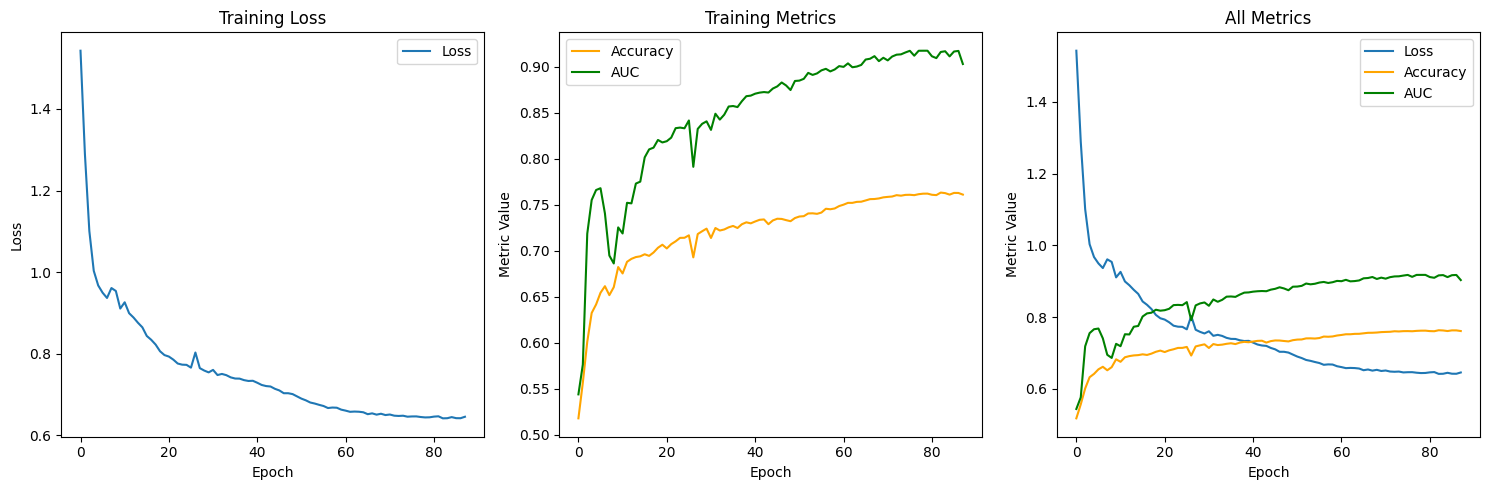

In [ ]:
train_losses = []
train_accuracies = []
train_aucs = []
best_loss = float('inf')
patience = 5
no_improve_epochs = 0
min_delta = 0.001



for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    embeddings = model(snapshots, node_feats)

    pos_scores = []
    neg_scores = []
    for snapshot in snapshots:
        if snapshot['edge_index'].shape[1] == 0:
            continue

        src, dst = snapshot['edge_index']
        pos_scores.append(F.cosine_similarity(embeddings[-1][src], embeddings[-1][dst]) * 5.0)

        neg_edge_index = negative_sampling(
            edge_index=snapshot['edge_index'],
            num_nodes=len(node_feats),
            num_neg_samples=len(src)
        )

        neg_src, neg_dst = neg_edge_index
        neg_scores.append(F.cosine_similarity(embeddings[-1][neg_src], embeddings[-1][neg_dst]) * 5.0)

    if not pos_scores:
        continue

    scores = torch.cat([torch.cat(pos_scores), torch.cat(neg_scores)])
    labels = torch.cat([torch.ones_like(torch.cat(pos_scores)), torch.zeros_like(torch.cat(neg_scores))])

    loss = F.binary_cross_entropy_with_logits(scores, labels)

    with torch.no_grad():
        predictions = (torch.sigmoid(scores) > 0.5).float()
        accuracy = (predictions == labels).float().mean()
        train_accuracies.append(accuracy.item())

        from sklearn.metrics import roc_auc_score
        probs = torch.sigmoid(scores).cpu().numpy()
        y_true = labels.cpu().numpy()
        try:
            auc = roc_auc_score(y_true, probs)
            train_aucs.append(auc)
        except:
            train_aucs.append(0.5)

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if loss.item() < best_loss - min_delta:
        best_loss = loss.item()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Accuracy: {accuracy.item():.4f} | AUC: {train_aucs[-1]:.4f} | Patience: {no_improve_epochs}/{patience}")

    if no_improve_epochs >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}!")
        break

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Metrics')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy', color='orange')
plt.plot(train_aucs, label='AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('All Metrics')
plt.legend()

plt.tight_layout()
plt.show()


Node embeddings with t-SNE:


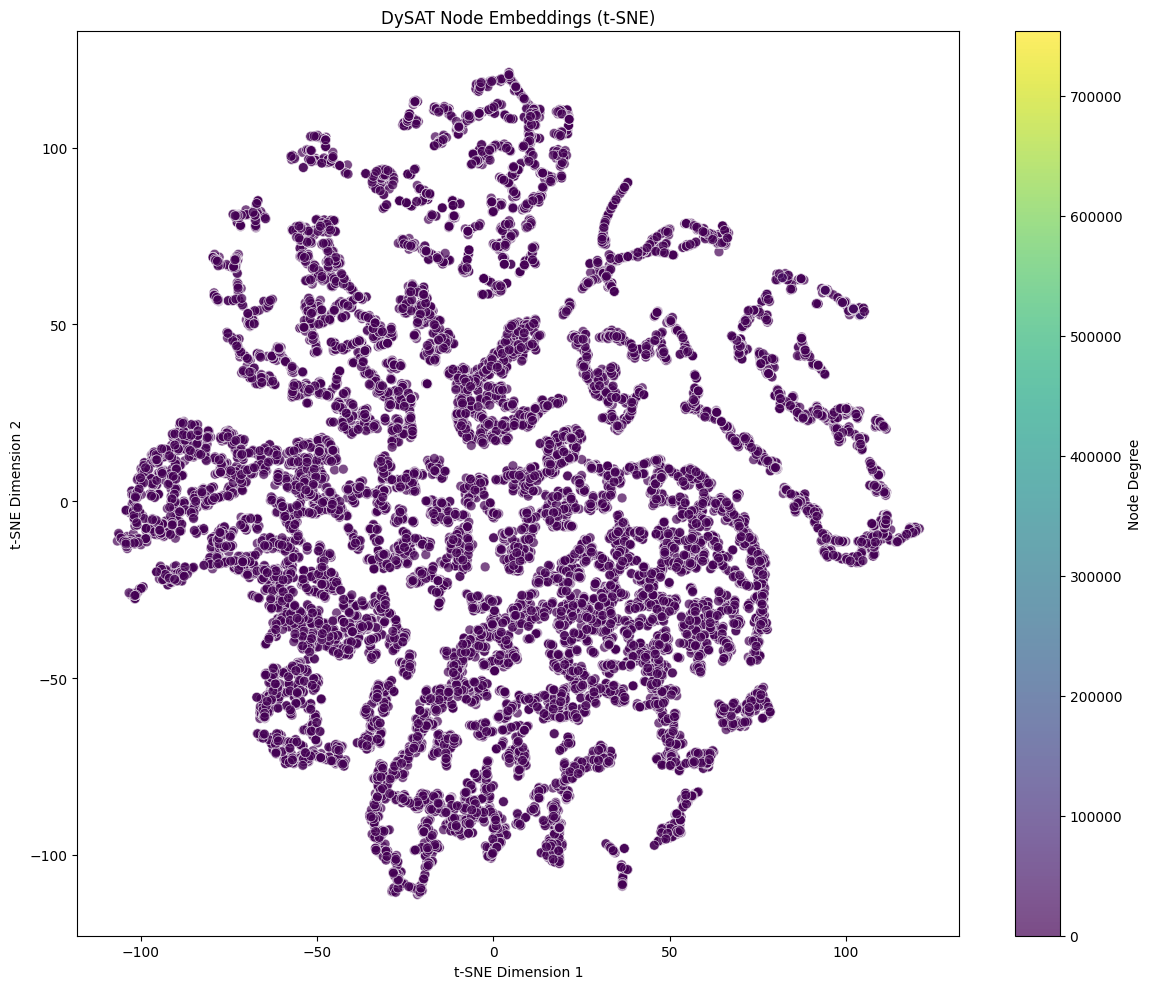

In [ ]:
print("\nNode embeddings with t-SNE:")
tsne_embeddings = visualize_embeddings_tsne(
    model,
    snapshots,
    node_feats,
    title="DySAT Node Embeddings"
)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

In [ ]:
edge_lookup = {}
for _, row in edges_train.iterrows():

    key = (row['src_id'], row['dst_id'], row['edge_type'])
    if key not in edge_lookup:
        edge_lookup[key] = []
    edge_lookup[key].append(row['timestamp'])

    key_rev = (row['dst_id'], row['src_id'], row['edge_type'])
    if key_rev not in edge_lookup:
        edge_lookup[key_rev] = []
    edge_lookup[key_rev].append(row['timestamp'])

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

def predict_with_model(model, test_data, snapshots, node_feats):
    """Use the trained DySAT model to make predictions"""
    model.eval()
    with torch.no_grad():
        embeddings = model(snapshots, node_feats)

    results = []
    for _, row in test_data.iterrows():
        src, dst = int(row['src_id']), int(row['dst_id'])
        start_bin, end_bin = int(row['start_bin']), int(row['end_bin'])

        if src >= len(embeddings[0]) or dst >= len(embeddings[0]):
            results.append(0)
            continue


        snapshot_indices = []
        for i, time_bin in enumerate(range(num_time_bins)):
            if i < len(embeddings) and start_bin <= time_bin <= end_bin:
                snapshot_indices.append(i)

        if not snapshot_indices:
            snapshot_indices = [len(embeddings)-1]

        similarities = []
        for idx in snapshot_indices:
            src_emb = embeddings[idx][src]
            dst_emb = embeddings[idx][dst]
            similarity = F.cosine_similarity(src_emb.unsqueeze(0), dst_emb.unsqueeze(0)).item() * 5.0
            similarities.append(similarity)

        avg_similarity = sum(similarities) / len(similarities)

        probability = torch.sigmoid(torch.tensor(avg_similarity)).item()
        results.append(probability)

    return results

def derive_ground_truth(test_data, edges_train):
    print("Code in the derive_ground_truth method...")
    ground_truth = []

    for _, row in test_data.iterrows():
        src, dst, edge_type = row['src_id'], row['dst_id'], row['edge_type']
        start_bin, end_bin = row['start_bin'], row['end_bin']

        key = (src, dst, edge_type)
        if key in edge_lookup:
            exists = any(start_bin <= pd.cut([ts], bins=time_bin_edges, labels=False)[0] <= end_bin
                         for ts in edge_lookup[key] if not pd.isna(pd.cut([ts], bins=time_bin_edges, labels=False)[0]))
        else:
            exists = False

        ground_truth.append(1 if exists else 0)

    return ground_truth
model_probs = predict_with_model(model, test_data, snapshots, node_feats)

ground_truth = derive_ground_truth(test_data, edges_train)


Code in the derive_ground_truth method...


In [ ]:
def visualize_prediction_results(model, test_data, snapshots, node_feats, ground_truth, predictions,
                               threshold=0.5, max_links=100, title="Link Prediction Results"):

    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D


    pred_labels = [1 if p > threshold else 0 for p in predictions]


    true_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                           if gt == 1 and pred == 1]

    false_negative_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 1 and pred == 0]

    false_positive_indices = [i for i, (gt, pred) in enumerate(zip(ground_truth, pred_labels))
                            if gt == 0 and pred == 1]


    sample_size = max_links // 3

    sampled_indices = []

    if true_positive_indices:
        tp_sample = np.random.choice(true_positive_indices,
                                    min(sample_size, len(true_positive_indices)),
                                    replace=False)
        sampled_indices.extend(tp_sample)

    if false_negative_indices:
        fn_sample = np.random.choice(false_negative_indices,
                                    min(sample_size, len(false_negative_indices)),
                                    replace=False)
        sampled_indices.extend(fn_sample)

    if false_positive_indices:
        fp_sample = np.random.choice(false_positive_indices,
                                    min(sample_size, len(false_positive_indices)),
                                    replace=False)
        sampled_indices.extend(fp_sample)

    if not sampled_indices:
        print("No links to visualize.")
        return

    G = nx.Graph()

    for idx in sampled_indices:
        src = test_data.iloc[idx]['src_id']
        dst = test_data.iloc[idx]['dst_id']
        prob = predictions[idx]
        gt = ground_truth[idx]
        pred = pred_labels[idx]

        if gt == 1 and pred == 1:
            pred_type = "true_positive"
        elif gt == 1 and pred == 0:
            pred_type = "false_negative"
        elif gt == 0 and pred == 1:
            pred_type = "false_positive"
        else:
            pred_type = "true_negative"

        G.add_edge(src, dst,
                  weight=prob,
                  probability=f"{prob:.2f}",
                  ground_truth=gt,
                  prediction=pred,
                  pred_type=pred_type)

    edge_list = list(G.edges())
    if not edge_list:
        print("No edges to visualize.")
        return

    model.eval()
    with torch.no_grad():
        embeddings = model(snapshots, node_feats)
        node_embeddings = embeddings[-1]

    plt.figure(figsize=(14, 12))

    pos = nx.spring_layout(G, seed=42)

    node_colors = []
    for node in G.nodes():
        if node < len(node_embeddings):
            node_colors.append(node_embeddings[node][0].item())
        else:
            node_colors.append(0)

    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        node_size=150,
        alpha=0.8
    )

    edge_colors = []
    edge_widths = []

    for u, v, data in G.edges(data=True):
        pred_type = data['pred_type']
        if pred_type == "true_positive":
            edge_colors.append('green')
            edge_widths.append(2.0)
        elif pred_type == "false_negative":
            edge_colors.append('red')
            edge_widths.append(1.5)
        elif pred_type == "false_positive":
            edge_colors.append('orange')
            edge_widths.append(1.5)
        else:
            edge_colors.append('blue')
            edge_widths.append(1.0)

    edges = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7
    )

    high_conf_edges = {(u, v): f"{G[u][v]['probability']}"
                      for u, v in G.edges()
                      if float(G[u][v]['probability']) > 0.8 or float(G[u][v]['probability']) < 0.2}

    if len(high_conf_edges) < 50:
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=high_conf_edges,
            font_size=8
        )

    if len(G.nodes()) < 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    else:
        degrees = dict(G.degree())
        top_nodes = {node: str(node) for node, degree in degrees.items()
                    if degree > np.percentile(list(degrees.values()), 75)}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8)

    plt.colorbar(nodes, label="Node Embedding Value")

    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='True Positive (Correct Link)'),
        Line2D([0], [0], color='red', lw=2, label='False Negative (Missed Link)'),
        Line2D([0], [0], color='orange', lw=2, label='False Positive (False Link)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f"{title} (showing {len(G.edges())} links)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    tp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'true_positive')
    fn = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_negative')
    fp = sum(1 for _, _, d in G.edges(data=True) if d['pred_type'] == 'false_positive')

    print(f"Visualization Statistics:")
    print(f"Total links shown: {len(G.edges())}")
    print(f"Correctly predicted links (True Positives): {tp}")
    print(f"Missed links (False Negatives): {fn}")
    print(f"Falsely predicted links (False Positives): {fp}")

    total_tp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 1)
    total_fn = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 1 and pred == 0)
    total_fp = sum(1 for gt, pred in zip(ground_truth, pred_labels) if gt == 0 and pred == 1)

    print(f"\nOverall Model Performance:")
    print(f"Total True Positives: {total_tp}")
    print(f"Total False Negatives: {total_fn}")
    print(f"Total False Positives: {total_fp}")
    if total_tp + total_fn > 0:
        recall = total_tp / (total_tp + total_fn)
        print(f"Recall: {recall:.4f}")
    if total_tp + total_fp > 0:
        precision = total_tp / (total_tp + total_fp)
        print(f"Precision: {precision:.4f}")

In [ ]:
fixed_threshold = 0.5
final_predictions = [1 if p > fixed_threshold else 0 for p in model_probs]

accuracy = accuracy_score(ground_truth, final_predictions)
f1 = f1_score(ground_truth, final_predictions)
auc = roc_auc_score(ground_truth, model_probs)

results = {
    'threshold': fixed_threshold,
    'auc_score': auc,
    'accuracy': accuracy,
    'f1_score': f1,
    'num_test_samples': len(test_data)
}






Results with fixed threshold (0.5):
AUC Score: 0.7555
Accuracy: 0.7744
F1 Score: 0.8695


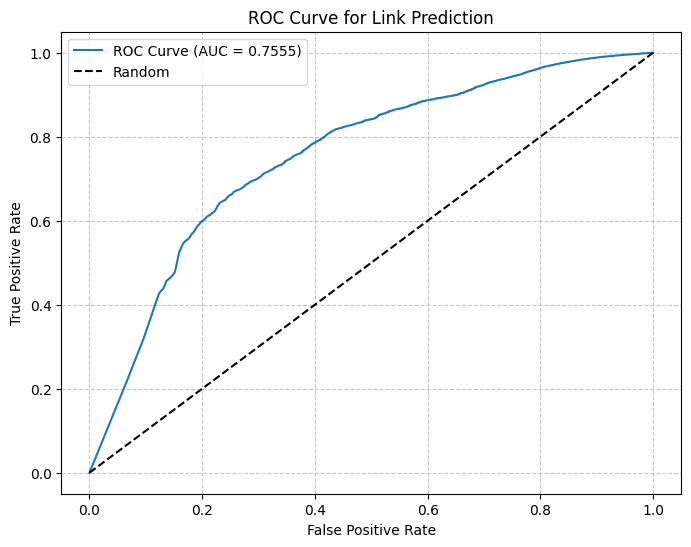

<Figure size 800x600 with 0 Axes>

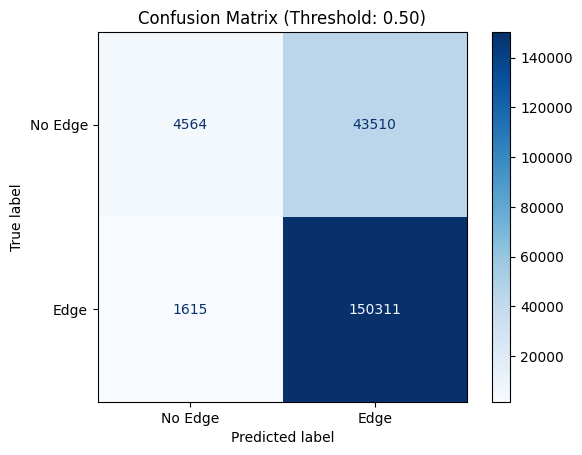

In [ ]:
print("\nResults with fixed threshold (0.5):")
print(f"AUC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

fpr, tpr, _ = roc_curve(ground_truth, model_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


cm = confusion_matrix(ground_truth, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {fixed_threshold:.2f})')
plt.show()

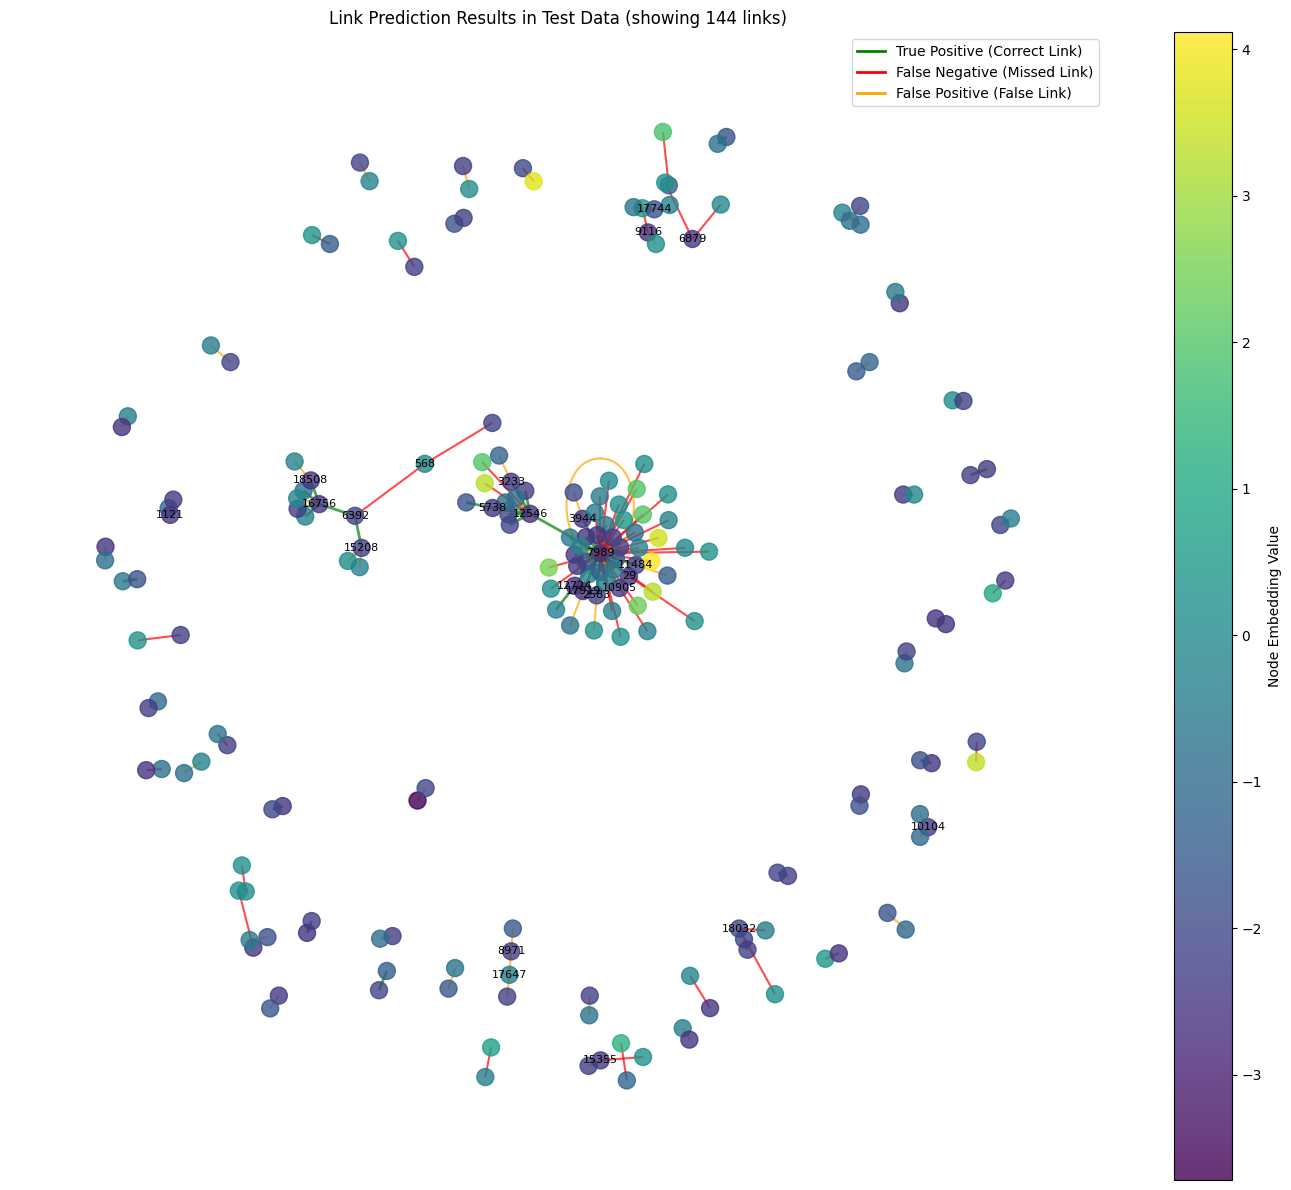

Visualization Statistics:
Total links shown: 144
Correctly predicted links (True Positives): 46
Missed links (False Negatives): 50
Falsely predicted links (False Positives): 48

Overall Model Performance:
Total True Positives: 150311
Total False Negatives: 1615
Total False Positives: 43510
Recall: 0.9894
Precision: 0.7755


In [ ]:
visualize_prediction_results(
    model,
    test_data,
    snapshots,
    node_feats,
    ground_truth,
    model_probs,
    threshold=fixed_threshold,
    max_links=150,
    title="Link Prediction Results in Test Data"
)

In [ ]:
from sklearn.metrics import average_precision_score
ap = average_precision_score(ground_truth, model_probs)
print(f"Average Precision: {ap:.4f}")

Average Precision: 0.8873


In [ ]:
predictions_df = pd.DataFrame({
    'src_id': test_data['src_id'],
    'dst_id': test_data['dst_id'],
    'edge_type': test_data['edge_type'],
    'predicted_probability': model_probs,
    'predicted_label': final_predictions,
    'ground_truth': ground_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions, ground_truth)]
})
predictions_df.to_csv('dysat_model_results.csv', index=False)

In [ ]:
print("Train time range:", edges_train['timestamp'].min(), edges_train['timestamp'].max())
print("Test time range:", test_data['start_time'].min(), test_data['end_time'].max())

Train time range: 1413662400 1494705600
Test time range: 1494581188 1499122550


In [ ]:
train_end_time = edges_train['timestamp'].max()
overlap_ratio = (test_data['start_time'] < train_end_time).mean()
print(f" %{overlap_ratio*100:.2f} of test queries overlap with training time")

 %1.51 of test queries overlap with training time


In [ ]:
train_end_time = edges_train['timestamp'].max()
clean_test = test_data[test_data['start_time'] >= train_end_time]


clean_probs = predict_with_model(model, clean_test, snapshots, node_feats)
clean_truth = derive_ground_truth(clean_test, edges_train)



Code in the derive_ground_truth method...


In [ ]:
fixed_threshold_2 = 0.6
final_predictions_2 = [1 if p > fixed_threshold_2 else 0 for p in clean_probs]

clean_auc = roc_auc_score(clean_truth, final_predictions_2)
f1_2 = f1_score(clean_truth, final_predictions_2)
accuracy_2 = accuracy_score(clean_truth, final_predictions_2)


print("\n=== Temporal Leakage Analysis ===")
print(f"Original test size: {len(test_data)}")
print(f"Clean test size: {len(clean_test)} ({len(clean_test)/len(test_data):.1%} of original)")
print(f"Clean test AUC (no leakage): {clean_auc:.4f}")
print(f"AUC difference: {auc-clean_auc:+.4f}")
print(f"Accuracy: {accuracy_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")


=== Temporal Leakage Analysis ===
Original test size: 200000
Clean test size: 196982 (98.5% of original)
Clean test AUC (no leakage): 0.5554
AUC difference: +0.2001
Accuracy: 0.7808
F1 Score: 0.8726


In [ ]:
print("Class balance:", np.mean(clean_truth))

Class balance: 0.763079875318557


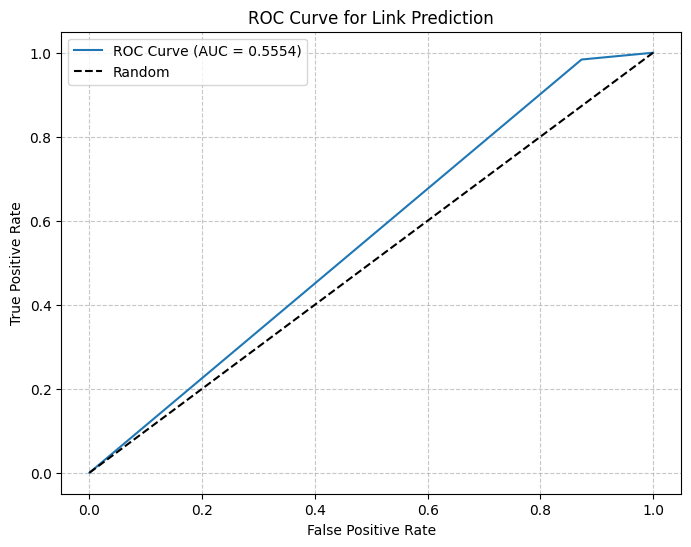

<Figure size 800x600 with 0 Axes>

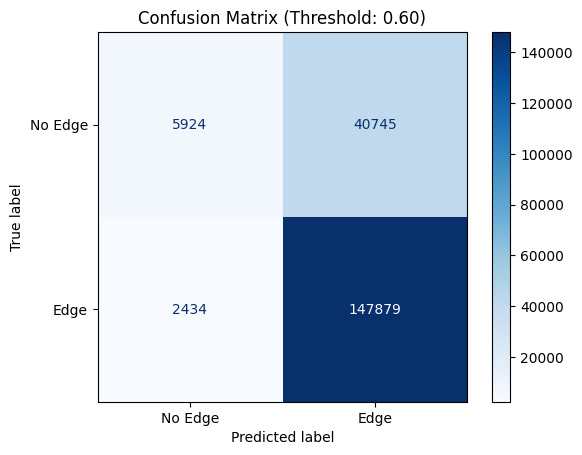

In [ ]:
fpr, tpr, _ = roc_curve(clean_truth, final_predictions_2)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {clean_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



cm = confusion_matrix(clean_truth, final_predictions_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Edge', 'Edge'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {fixed_threshold_2:.2f})')
plt.show()

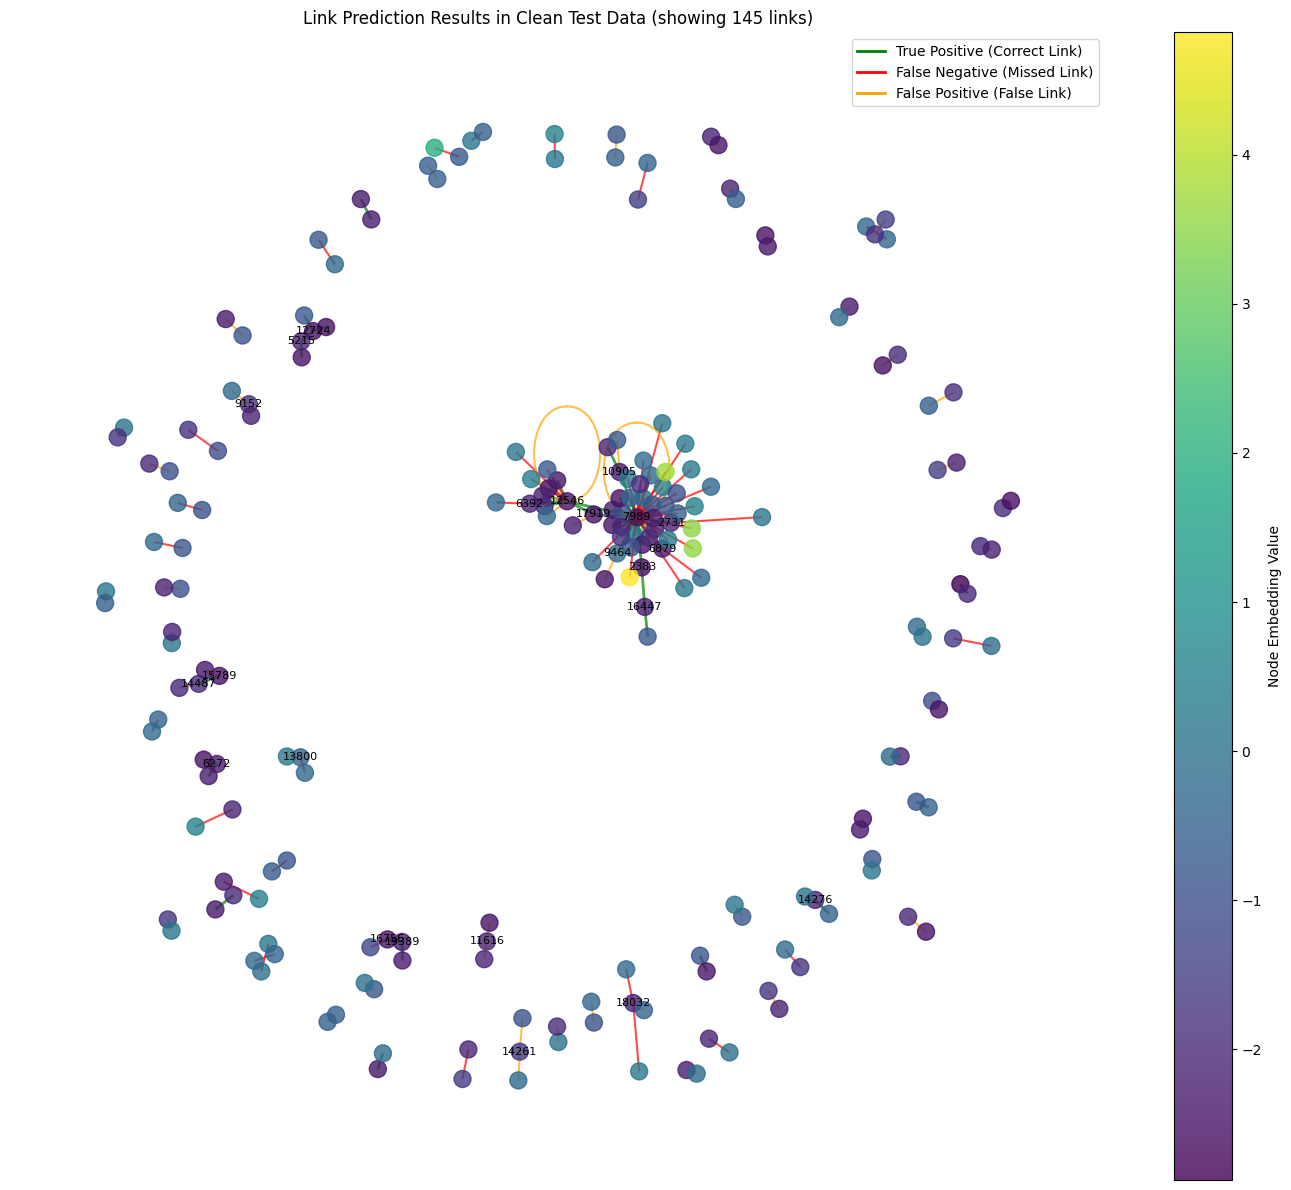

Visualization Statistics:
Total links shown: 145
Correctly predicted links (True Positives): 48
Missed links (False Negatives): 49
Falsely predicted links (False Positives): 48

Overall Model Performance:
Total True Positives: 147879
Total False Negatives: 2434
Total False Positives: 40745
Recall: 0.9838
Precision: 0.7840


In [ ]:
visualize_prediction_results(
    model,
    clean_test,
    snapshots,
    node_feats,
    clean_truth,
    clean_probs,
    threshold=fixed_threshold_2,
    max_links=150,
    title="Link Prediction Results in Clean Test Data"
)

In [ ]:
print("Test data size:", len(test_data))

Test data size: 200000


In [ ]:
predictions_df_clear_data = pd.DataFrame({
    'src_id': clean_test['src_id'],
    'dst_id': clean_test['dst_id'],
    'edge_type': clean_test['edge_type'],
    'predicted_probability': clean_probs,
    'predicted_label': final_predictions_2,
    'ground_truth': clean_truth,
    'correct_prediction': [1 if pred == true else 0 for pred, true in zip(final_predictions_2, clean_truth)]
})
predictions_df_clear_data.to_csv('dysat_model_results_clean.csv', index=False)